# <center> SOA Session 3A - Storytelling with Data </center>

## Collateral Monitoring Tool v1.01

<u>Developer:</u> David Ahn

<u>Date:</u> 5/24/2022

<u>Purpose:</u> To monitor daily collateral amount by calculating present value of future projected cashflows

<u>Summary:</u> 

Collateral amount is the future obligated cashflows the company needs to hold in the bank account to ensure solvency for company's longevity risk. 

The tool will calculate PVs of Best Estimate, Best Scenario, and Worst Scenario 
- Best Scenario: More people are dying than expected. 
- Worst Scenario: Less people are dying than expected. 

<u>Assumptions</u>:
- CF = 100,000
- annual_qx = 0.03 
- base_mortality_shock = 50%

<u>Valuation Discount Factor</u>: Simple US Treasury Curve

<u>Procedure:</u>
1. Import python libraries
2. Import US treasury yield curve
3. Calculate valuation discount factor (vdf) using linear interpolation
4. Calculate survivorship factor for BE, Best, and Worst Scenarios
5. Calculate PVs using survivorship and vdf
6. Results Summary
7. Export output

<u>Resources:</u>
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield





## 1. Library Import

The following libraries are used throughout the tool

- <u>numpy</u> - Used for numerical calculations working with arrays
- <u>pandas</u> - Working with tabular data with rows and columns as dataframes to process data
- <u>matplotlib.pyplot</u> - Create and work with data visualization
- <u>datetime</u> - Convert date format
- <u>scipy</u> - Used for linear interpolation



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.interpolate

## 2. Yield Curve

Import daily US treasury yield curve rates 

Valuation Date: 05-24-2022


,Tenors,Rate
0,1 Mo,0.55
1,2 Mo,0.88
2,3 Mo,1.06
3,6 Mo,1.53
4,1 Yr,2.02
5,2 Yr,2.50
6,3 Yr,2.66
7,5 Yr,2.76
8,7 Yr,2.80
9,10 Yr,2.76


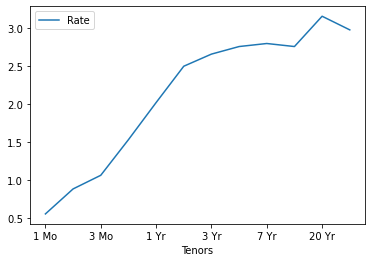

In [6]:
# Create dataframe from .csv file from the most recent valuation date
treasury_curve = pd.read_csv('daily-treasury-rates.csv', index_col=0, nrows=1)
treasury_curve_final = treasury_curve.transpose().reset_index()

# Generate valuation date
val_date = datetime.strptime(treasury_curve_final.columns[1], '%m/%d/%Y').strftime('%m-%d-%Y')

# Set up columns
columns = ['Tenors', 'Rate']
treasury_curve_final.columns = columns

# Print results
print(f'Valuation Date: {val_date}')
treasury_curve_final.plot(x='Tenors', y='Rate')
treasury_curve_final


## 3. Valuation Discount Factor (VDF)

#### Calculate Valuation Discount Factor from the yield curve and applying linear interpolation method

Calculate Maturities on annual basis, which will be used in the linear interpolation

In [7]:
treasury_curve_final['Maturities'] = np.where(
    treasury_curve_final['Tenors'].str[-2:]=='Mo', 
    treasury_curve_final['Tenors'].str[:1].astype(int)/12,
    treasury_curve_final['Tenors'].str[:2].astype(int)
)

treasury_curve_final

,Tenors,Rate,Maturities
0,1 Mo,0.55,0.083333
1,2 Mo,0.88,0.166667
2,3 Mo,1.06,0.250000
3,6 Mo,1.53,0.500000
4,1 Yr,2.02,1.000000
5,2 Yr,2.50,2.000000
6,3 Yr,2.66,3.000000
7,5 Yr,2.76,5.000000
8,7 Yr,2.80,7.000000
9,10 Yr,2.76,10.000000


Cashflows will project out for 30 years (360 months). Map the 30 year projection with Rates and Maturies from the yield curve above

In [8]:
# Create a new dataframe with months and years
df = pd.DataFrame({'Months': range(1,361)})
df['Year'] = df['Months']/12

# Map treasury yield curve
df_final = df.merge(treasury_curve_final, left_on='Year', right_on='Maturities', how='left').fillna(method='ffill')

df_final


,Months,Year,Tenors,Rate,Maturities
0,1,0.083333,1 Mo,0.55,0.083333
1,2,0.166667,2 Mo,0.88,0.166667
2,3,0.250000,3 Mo,1.06,0.250000
3,4,0.333333,3 Mo,1.06,0.250000
4,5,0.416667,3 Mo,1.06,0.250000
...,...,...,...,...,...
355,356,29.666667,20 Yr,3.16,20.000000
356,357,29.750000,20 Yr,3.16,20.000000
357,358,29.833333,20 Yr,3.16,20.000000
358,359,29.916667,20 Yr,3.16,20.000000


## <center>Linear Interpolation</center>



Linear interpolation function is defined as follows:

$$ y(x)  =  y_1  +  (x – x_1)  \frac{(y_2 – y_1) }{ (x_2 – x_1)} $$

Use scipy package to linearly interpolate the rates across 360 months

In [9]:
# Linear Interpolation
y_interp = scipy.interpolate.interp1d(df_final['Maturities'], df_final['Rate'])
df_final['Rate_Interpolated'] = y_interp(df_final['Year'])

df_final

,Months,Year,Tenors,Rate,Maturities,Rate_Interpolated
0,1,0.083333,1 Mo,0.55,0.083333,0.550000
1,2,0.166667,2 Mo,0.88,0.166667,0.880000
2,3,0.250000,3 Mo,1.06,0.250000,1.060000
3,4,0.333333,3 Mo,1.06,0.250000,1.216667
4,5,0.416667,3 Mo,1.06,0.250000,1.373333
...,...,...,...,...,...,...
355,356,29.666667,20 Yr,3.16,20.000000,2.986000
356,357,29.750000,20 Yr,3.16,20.000000,2.984500
357,358,29.833333,20 Yr,3.16,20.000000,2.983000
358,359,29.916667,20 Yr,3.16,20.000000,2.981500


<u>David's Comment:</u> This is much easier and cleaner than writing linear interpolation formula from scratch! As we've discussed, python is open-source where we can use libraries developed by 3rd party, where it has been fully tested and documented

Calculate Valuation Discount Factor (VDF)

In [10]:
df_final.drop(['Tenors', 'Rate', 'Maturities'], axis=1, inplace=True)

df_final['VDF'] = (1 + df_final['Rate_Interpolated'] / 100) ** (-df_final['Year'])

df_final

,Months,Year,Rate_Interpolated,VDF
0,1,0.083333,0.550000,0.999543
1,2,0.166667,0.880000,0.998541
2,3,0.250000,1.060000,0.997367
3,4,0.333333,1.216667,0.995977
4,5,0.416667,1.373333,0.994333
...,...,...,...,...
355,356,29.666667,2.986000,0.417747
356,357,29.750000,2.984500,0.416905
357,358,29.833333,2.983000,0.416065
358,359,29.916667,2.981500,0.415228


## Assumptions and Inputs

In [11]:
CF = 100000
annual_qx = 0.03
monthly_qx = annual_qx/12
base_mortality_shock = 0.5

## 4. Cumulative Survivorship using q(x)

Calculate cumulative survivorship for BE, Best, and Worst based on the 50% mortality shocks

In [12]:
df_final['CFs'] = CF
df_final['Survivorship'] = (1-monthly_qx)
df_final['Survivorship_Best'] = (1-monthly_qx*(1+base_mortality_shock))
df_final['Survivorship_Worst'] = (1-monthly_qx/(1+base_mortality_shock))

df_final['Cumulative_Survivorship'] = df_final['Survivorship'].cumprod()
df_final['Cumulative_Survivorship_Best'] = df_final['Survivorship_Best'].cumprod()
df_final['Cumulative_Survivorship_Worst'] = df_final['Survivorship_Worst'].cumprod()

df_final


,Months,Year,Rate_Interpolated,VDF,CFs,Survivorship,Survivorship_Best,Survivorship_Worst,Cumulative_Survivorship,Cumulative_Survivorship_Best,Cumulative_Survivorship_Worst
0,1,0.083333,0.550000,0.999543,100000,0.9975,0.99625,0.998333,0.997500,0.996250,0.998333
1,2,0.166667,0.880000,0.998541,100000,0.9975,0.99625,0.998333,0.995006,0.992514,0.996669
2,3,0.250000,1.060000,0.997367,100000,0.9975,0.99625,0.998333,0.992519,0.988792,0.995008
3,4,0.333333,1.216667,0.995977,100000,0.9975,0.99625,0.998333,0.990037,0.985084,0.993350
4,5,0.416667,1.373333,0.994333,100000,0.9975,0.99625,0.998333,0.987562,0.981390,0.991694
...,...,...,...,...,...,...,...,...,...,...,...
355,356,29.666667,2.986000,0.417747,100000,0.9975,0.99625,0.998333,0.410198,0.262499,0.552209
356,357,29.750000,2.984500,0.416905,100000,0.9975,0.99625,0.998333,0.409173,0.261514,0.551289
357,358,29.833333,2.983000,0.416065,100000,0.9975,0.99625,0.998333,0.408150,0.260534,0.550370
358,359,29.916667,2.981500,0.415228,100000,0.9975,0.99625,0.998333,0.407130,0.259557,0.549453


## 5. PVs

Calculate PV for BE, Best, and Worst scenarios

In [13]:
df_final['Decremented_CFs'] = CF * df_final['Cumulative_Survivorship'] 
df_final['Decremented_CFs_Best'] = CF * df_final['Cumulative_Survivorship_Best'] 
df_final['Decremented_CFs_Worst'] = CF * df_final['Cumulative_Survivorship_Worst'] 

df_final['PV'] = df_final['VDF'] * df_final['Decremented_CFs']
df_final['PV_Best'] = df_final['VDF'] * df_final['Decremented_CFs_Best']
df_final['PV_Worst'] = df_final['VDF'] * df_final['Decremented_CFs_Worst']

df_final

,Months,Year,Rate_Interpolated,VDF,CFs,Survivorship,Survivorship_Best,Survivorship_Worst,Cumulative_Survivorship,Cumulative_Survivorship_Best,Cumulative_Survivorship_Worst,Decremented_CFs,Decremented_CFs_Best,Decremented_CFs_Worst,PV,PV_Best,PV_Worst
0,1,0.083333,0.550000,0.999543,100000,0.9975,0.99625,0.998333,0.997500,0.996250,0.998333,99750.000000,99625.000000,99833.333333,99704.416936,99579.474057,99787.712188
1,2,0.166667,0.880000,0.998541,100000,0.9975,0.99625,0.998333,0.995006,0.992514,0.996669,99500.625000,99251.406250,99666.944444,99355.435151,99106.580057,99521.511905
2,3,0.250000,1.060000,0.997367,100000,0.9975,0.99625,0.998333,0.992519,0.988792,0.995008,99251.873438,98879.213477,99500.832870,98990.584729,98618.905826,99238.888756
3,4,0.333333,1.216667,0.995977,100000,0.9975,0.99625,0.998333,0.990037,0.985084,0.993350,99003.743754,98508.416426,99334.998149,98605.454796,98112.120154,98935.376565
4,5,0.416667,1.373333,0.994333,100000,0.9975,0.99625,0.998333,0.987562,0.981390,0.991694,98756.234395,98139.009864,99169.439819,98196.566382,97582.839766,98607.430102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,29.666667,2.986000,0.417747,100000,0.9975,0.99625,0.998333,0.410198,0.262499,0.552209,41019.839025,26249.863408,55220.919511,17135.928337,10965.810420,23068.391831
356,357,29.750000,2.984500,0.416905,100000,0.9975,0.99625,0.998333,0.409173,0.261514,0.551289,40917.289428,26151.426420,55128.884645,17058.619356,10902.658391,22983.503351
357,358,29.833333,2.983000,0.416065,100000,0.9975,0.99625,0.998333,0.408150,0.260534,0.550370,40814.996204,26053.358571,55037.003171,16981.700486,10839.896437,22898.982983
358,359,29.916667,2.981500,0.415228,100000,0.9975,0.99625,0.998333,0.407130,0.259557,0.549453,40712.958714,25955.658477,54945.274832,16905.169597,10777.522008,22814.828962


## 6. Results Summary

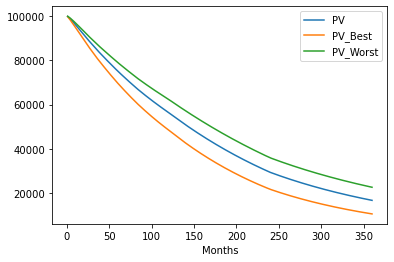

In [14]:
df_final.plot(kind='line',x='Months',y=['PV', 'PV_Best', 'PV_Worst'])

plt.show()

In [15]:
total = pd.Series({'PV': df_final.PV.sum(), 'PV_Best': df_final.PV_Best.sum(), 'PV_Worst': df_final.PV_Worst.sum()})

total.name = 'Total'

df_final_total = df_final.append(total).fillna('')

print(f'PV: {df_final.PV.sum()}')
print(f'PV (Best Scenario): {df_final.PV_Best.sum()}')
print(f'PV (Worst Scenario): {df_final.PV_Worst.sum()}')

PV: 16816770.599330105
PV (Best Scenario): 14413331.727163978
PV (Worst Scenario): 18784355.1026828


/var/folders/pc/v1sm70654q7c4hm8h1f3g8l00000gn/T/ipykernel_76107/1038555026.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_total = df_final.append(total).fillna('')


## 7. Export the Output



In [16]:
df_final_total.to_csv(f'collateral_validation_{val_date}.csv')